## ECGR 5106 - Homework 1

Naseeruddin Lodge
801200144


## Problem 1

1.a.

In [1]:
!pip install d2l==1.0.0b0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.6/141.6 KB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 36.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 KB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 KB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 KB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.5 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616824 sha256=df8b2ad7e4715e4dbf907ab8b31ded246b8ffc0dab8b32b049b11fa4d4a202d4
  Stored in directory: /root/.cache/pip/wheels/27/6d/b3/a3a6e10704795c9b9000f1ab2dc480dfe7bed42f5972806e73
Successfully built gym
  Attempting uninstal

In [2]:
# Importing all the Necessary Libraries

%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import time
import torchvision
import torch.nn.functional as F   
from torchvision import transforms
from d2l import torch as d2l
from torch import nn

import torch
torch.__version__
torch.cuda.current_device()
torch.cuda.get_device_name(0)

d2l.use_svg_display()

# Code Snippet to Ignore Warning

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Loading the FashionMNIST Dataset 
class FashionMNIST(d2l.DataModule): 
  def __init__(self, batch_size = 64, resize = (28, 28)):
    super().__init__()
    self.save_hyperparameters()
    trans = transforms.Compose([transforms.Resize(resize),
                                transforms.ToTensor()])
    self.train = torchvision.datasets.FashionMNIST(
        root = self.root, train = True, transform = trans, download = True)
    self.val = torchvision.datasets.FashionMNIST(
        root = self.root, train = False, transform = trans, download = True)


In [4]:
data = FashionMNIST(resize = (32, 32))
print("Training Images   = ", len(data.train))
print("Validation Images = ", len(data.val))

data.train[0][0].shape

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw

Training Images   =  60000
Validation Images =  10000


torch.Size([1, 32, 32])

In [5]:
# Function that Converts between Numeric Labels and the Class Names
@d2l.add_to_class(FashionMNIST)
def text_labels(self, indices):
  labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 
           'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
  return [labels[int(i)] for i in indices]


@d2l.add_to_class(FashionMNIST)
def get_dataloader(self, train):
  data = self.train if train else self.val
  return torch.utils.data.DataLoader(data, self.batch_size, shuffle = train,
                                     num_workers = self.num_workers)
  
X, Y = next(iter(data.train_dataloader()))
print(X.shape, X.dtype, Y.shape, Y.dtype)

torch.Size([64, 1, 32, 32]) torch.float32 torch.Size([64]) torch.int64


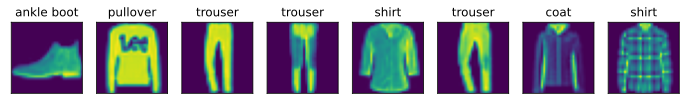

In [6]:
# Function to Display and Visualize the Images and their Corresponding Labels

def show_images(imgs, num_rows, num_cols, titles = None, scale = 1.5):
  raise NotImplementedError

@d2l.add_to_class(FashionMNIST)
def visualize(self, batch, nrows = 1, ncols = 8, labels = []):
  X, Y = batch
  if not labels:
    labels = self.text_labels(Y)
  d2l.show_images(X.squeeze(1), nrows, ncols, titles = labels)

batch = next(iter(data.val_dataloader()))
data.visualize(batch)

In [7]:
class Classifier(d2l.Module):
  def validation_step(self, batch):
    Y_hat = self(*batch[:-1])
    self.plot('Loss', self.loss(Y_hat, batch[-1]), train = False)
    self.plot('Acc', self.accuracy(Y_hat, batch[-1]), train = False)

@d2l.add_to_class(d2l.Module)
def configure_optimizers(self):
  return torch.optim.SGD(self.parameters(), lr = self.lr)

@d2l.add_to_class(Classifier)
def accuracy(self, Y_hat, Y, averaged = True):
  Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
  Preds = Y_hat.argmax(axis = 1).type(Y.dtype)
  compare = (Preds == Y.reshape(-1)).type(torch.float32)
  return compare.mean() if averaged else compare


class SoftmaxRegression(d2l.Classifier):
  def __init__(self, num_outputs, hidden_layer1, hidden_layer2, hidden_layer3, lr):
    super().__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(nn.Flatten(),
                             nn.LazyLinear(hidden_layer1),
                             nn.ReLU(),
                             nn.LazyLinear(hidden_layer2),
                             nn.ReLU(),
                             nn.LazyLinear(hidden_layer3),
                             nn.ReLU(),
                             nn.LazyLinear(num_outputs))
  def forward(self, X):
    return self.net(X)

@d2l.add_to_class(Classifier)
def loss(self, Y_hat, Y, averaged = True):
  Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
  Y = Y.reshape((-1))
  return F.cross_entropy(
      Y_hat, Y, reduction = 'mean' if averaged else 'none')

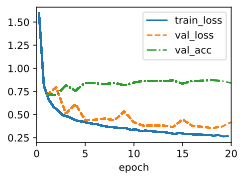

In [8]:
# Plotting over 20 Epochs (Basic Required for HW)
data = d2l.FashionMNIST(batch_size = 256)
model = SoftmaxRegression(num_outputs = 10, hidden_layer1 = 512, hidden_layer2 = 256, hidden_layer3 = 256, lr = 0.1)
trainer = d2l.Trainer(max_epochs = 20)
trainer.fit(model, data)

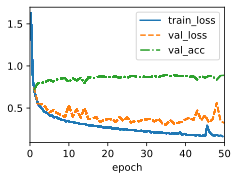

In [9]:
# Plotting over 50 Epochs for Comparison
data = d2l.FashionMNIST(batch_size = 256)
model = SoftmaxRegression(num_outputs = 10, hidden_layer1 = 512, hidden_layer2 = 256, hidden_layer3 = 256, lr = 0.1)
trainer = d2l.Trainer(max_epochs = 50)
trainer.fit(model, data)

1.b.

In [10]:
# Defining the the l2 Norm Penalty
def l2_penalty(w):
  return (w ** 2).sum() / 2
  

# Defining the Model with Weight Decay Property added
class WeightDecay(Classifier):
  def __init__(self, num_outputs, hidden_layer1, hidden_layer2, hidden_layer3, wd, lr, sigma = 0.01):
    super().__init__(lr)
    self.save_hyperparameters()
    self.wd = wd
    self.weights = torch.normal(0, sigma, (hidden_layer1, 1), requires_grad=True)
    self.net = nn.Sequential(nn.Flatten(),
                             nn.LazyLinear(hidden_layer1),
                             nn.ReLU(),
                             nn.LazyLinear(hidden_layer2),
                             nn.ReLU(),
                             nn.LazyLinear(hidden_layer3),
                             nn.ReLU(),
                             nn.LazyLinear(num_outputs))
  def forward(self, X):
    return self.net(X)
    
  # Defining the Loss Function with Penalty Added
  def loss(self, Y_hat, Y, averaged = True):
    Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
    Y = Y.reshape((-1))
    return (super().loss(Y_hat, Y) +
            self.wd * l2_penalty(self.weights))

data = d2l.FashionMNIST(batch_size = 256)
trainer = d2l.Trainer(max_epochs = 20)

def train_scratch():
  t_0 = time.time()
  model.board.yscale = 'log'
  trainer.fit(model, data)
  t_1 = time.time()
  print("Total Training Time (From Saved Model): ", t_1 - t_0)
  print()
  print()

Total Training Time (From Saved Model):  249.53344559669495




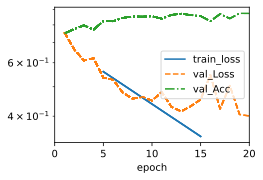

In [11]:
# Plotting the Results with Weight Decay Added 
model = WeightDecay(num_outputs = 10, hidden_layer1 = 512, hidden_layer2 = 256, hidden_layer3 = 256, wd = 2, lr = 0.1)
train_scratch()

# Saving the Weight Decay Model Parameters for Future Use
torch.save(model.state_dict(), 'MLP_weightDecay.params')

1.c.

In [12]:
class DropoutMLP(d2l.Classifier):
  def __init__(self, num_outputs, hidden_layer1, hidden_layer2, hidden_layer3, dropout_1, dropout_2, dropout_3, lr):
    super().__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(nn.Flatten(),
                             nn.LazyLinear(hidden_layer1),
                             nn.ReLU(),
                             nn.Dropout(dropout_1),
                             nn.LazyLinear(hidden_layer2),
                             nn.ReLU(),
                             nn.Dropout(dropout_2),
                             nn.LazyLinear(hidden_layer3),
                             nn.ReLU(),
                             nn.Dropout(dropout_3),
                             nn.LazyLinear(num_outputs))
  def forward(self, X):
    return self.net(X)

@d2l.add_to_class(Classifier)
def loss(self, Y_hat, Y, averaged = True):
  Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
  Y = Y.reshape((-1))
  return F.cross_entropy(
      Y_hat, Y, reduction = 'mean' if averaged else 'none')

Total Training Time (From Scratch):  258.0815212726593




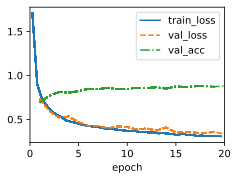

In [13]:
# Plotting over 20 Epochs 
t_0 = time.time()
data = d2l.FashionMNIST(batch_size = 256)
model = DropoutMLP(num_outputs = 10, hidden_layer1 = 512, hidden_layer2 = 256, hidden_layer3 = 256, dropout_1 = 0.3, dropout_2 = 0.3, dropout_3 = 0.3, lr = 0.1)
trainer = d2l.Trainer(max_epochs = 20)
trainer.fit(model, data)
t_1 = time.time()
print("Total Training Time (From Scratch): ", t_1 - t_0)
print()
print()

# Saving the Weight Decay Model Parameters for Future Use
torch.save(model.state_dict(), 'MLP_Dropout.params')

1.d.

Total Training Time (From Saved Model):  248.07758355140686




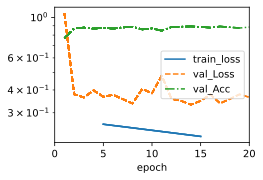

In [14]:
model = WeightDecay(num_outputs = 10, hidden_layer1 = 512, hidden_layer2 = 256, hidden_layer3 = 128, wd = 1, lr = 0.1)
model.load_state_dict(torch.load('MLP_weightDecay.params'))
train_scratch()

Total Training Time (From Saved Model):  256.1456093788147




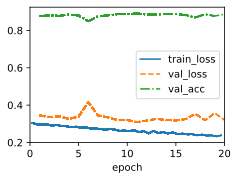

In [15]:
# Plotting over 20 Epochs 
t_0 = time.time()
model = DropoutMLP(num_outputs = 10, hidden_layer1 = 512, hidden_layer2 = 256, hidden_layer3 = 128, dropout_1 = 0.3, dropout_2 = 0.3, dropout_3 = 0.3, lr = 0.1)
model.load_state_dict(torch.load('MLP_Dropout.params'))
#saved_MLP_WeightDecay.eval()
trainer = d2l.Trainer(max_epochs = 20)
trainer.fit(model, data)
t_1 = time.time()
print("Total Training Time (From Saved Model): ", t_1 - t_0)
print()
print()



#PROBLEM 2

2.a. Standardization is used on continuous numerical features when the dataset has different ranges or features are in different units. Standardization is used in our case to avoid the date from producing misleading results.


2.b.

In [16]:
# Downloading and Caching the Housing Dataset from Kaggle
class KaggleHouse(d2l.DataModule):
    def __init__(self, batch_size, train=None, val=None):
        super().__init__()
        self.save_hyperparameters()
        if self.train is None:
            self.raw_train = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_train.csv', self.root,
                sha1_hash='585e9cc93e70b39160e7921475f9bcd7d31219ce'))
            self.raw_val = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_test.csv', self.root,
                sha1_hash='fa19780a7b011d9b009e8bff8e99922a8ee2eb90'))

In [17]:
# Loading the Dataset
data = KaggleHouse(batch_size = 64)
print(data.raw_train.shape)
print(data.raw_val.shape)

(1460, 81)
(1459, 80)


In [18]:
@d2l.add_to_class(KaggleHouse)
def preprocess(self):
    # Removing the ID and label columns
    label = 'SalePrice'
    features = pd.concat(
        (self.raw_train.drop(columns=['Id', label]),
         self.raw_val.drop(columns=['Id'])))
    
    # Standardizing the numerical columns
    numeric_features = features.dtypes[features.dtypes != 'object'].index
    features[numeric_features] = features[numeric_features].apply(
        lambda x: (x - x.mean()) / (x.std()))
    
    # Replacing NAN numerical features by 0
    features[numeric_features] = features[numeric_features].fillna(0)
    
    # Replacing discrete features by one-hot encoding.
    features = pd.get_dummies(features, dummy_na=True)
    
    # Saving preprocessed features
    self.train = features[:self.raw_train.shape[0]].copy()
    self.train[label] = self.raw_train[label]
    self.val = features[self.raw_train.shape[0]:].copy()

In [19]:
# Preprocessing the Data
data.preprocess()
print(data.train.shape)
print(data.val.shape)

(1460, 332)
(1459, 331)


In [20]:
# Creation of a Dataloader Function 
@d2l.add_to_class(KaggleHouse)
def get_dataloader(self, train):
    label = 'SalePrice'
    data = self.train if train else self.val
    if label not in data: return
    get_tensor = lambda x: torch.tensor(x.values, dtype=torch.float32)
    # Logarithm of prices
    tensors = (get_tensor(data.drop(columns=[label])),  # X
               torch.log(get_tensor(data[label])).reshape((-1, 1)))  # Y
    return self.get_tensorloader(tensors, train)

2.c.

In [21]:
# Defining the the l2 Norm Penalty for Weight Decay
def l2_penalty(w):
  return (w ** 2).sum() / 2

class LinearRegression(d2l.Module):
    def __init__(self, lr):
        self.save_hyperparameters()
        self.net = nn.LazyLinear(1024),
        self.net.ReLU(),
        self.net.Dropout(0.7),
        self.net.LazyLinear(512),
        self.net.ReLU(),
        self.net.Dropout(0.7),
        self.net.LazyLinear(128),
        self.net.ReLU(),
        self.net.Dropout(0.7),
        self.net.LazyLinear(32),
        self.net.ReLU(),
        self.net.Dropout(0.7),
        self.net.weight.data.normal_(0.5, 0.5),
        self.net.bias.data.fill_(0)

@d2l.add_to_class(LinearRegression) 
def forward(self, X):
    return self.net(X)

   # Defining the Loss Function with Penalty Added
    def loss(self, Y_hat, Y, averaged = True):
      Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
      Y = Y.reshape((-1))
      return (super().loss(Y_hat, Y) +
              self.wd * l2_penalty(self.weights))

@d2l.add_to_class(LinearRegression) 
def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(), self.lr)

In [22]:
def k_fold_data(data, k):
    rets = []
    fold_size = data.train.shape[0] // k
    for j in range(k):
        idx = range(j * fold_size, (j+1) * fold_size)
        rets.append(KaggleHouse(data.batch_size, data.train.drop(index=idx),
                                data.train.loc[idx]))
    return rets

In [23]:
def k_fold(trainer, data, k, lr):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        model = d2l.LinearRegression(lr)
        model.board.yscale='log'
        if i != 0: model.board.display = False
        trainer.fit(model, data_fold)
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
    print(f'average validation log mse = {sum(val_loss)/len(val_loss)}')
    return models

average validation log mse = 0.11221548200895388


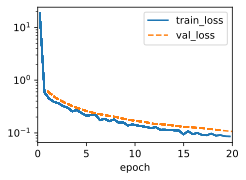

In [24]:
# Plotting the Complex model with both Dropout and Weight Decay 
trainer = d2l.Trainer(max_epochs=20)
models = k_fold(trainer, data, k=12, lr=0.01)

2.d.


In [26]:
# Getting the .csv File ready for submission on Kaggle
preds = [model(torch.tensor(data.val.values, dtype=torch.float32))
         for model in models]
# Taking exponentiation of predictions in the logarithm scale
ensemble_preds = torch.exp(torch.cat(preds, 1)).mean(1)
submission = pd.DataFrame({'Id':data.raw_val.Id,
                           'SalePrice':ensemble_preds.detach().numpy()})
submission.to_csv('submission.csv', index=False)